#Download Repositório

In [1]:
%cd Mask_RCNN-TF2/

e:\epoch\Mask_RCNN-TF2


In [2]:
%pip install -r requirements.txt

     ---------------------------------------- 14.8/14.8 MB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 988.1/988.1 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 7.6/7.6 MB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 23.7/23.7 MB 8.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.0rc1 Requires-Python >=3.7,<3.10; 1.7.0rc2 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.2 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.9.2

[notice] A new release of pip available: 22.3.

In [3]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\config.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\parallel_model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\utils.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\visualize.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\__init__.py -> build\bdist.win-amd64\egg\mrcnn
byte-compiling

c:\Users\Laura Aguiar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
c:\Users\Laura Aguiar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
c:\Users\Laura Aguiar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  warnings.warn(
c:\Users\Laura Aguiar\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\config\setupcfg.py:508: SetuptoolsDeprecationWarning: The license_file parameter is 

#Importação das bibliotecas

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pandas as pd

In [3]:
import skimage.draw
from skimage.io import imread

In [ ]:
import tensorflow
tensorflow.__version__

'2.9.2'

In [1]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

In [5]:
path_raiz = os.path.abspath('e:/epoch/Mask_RCNN-TF2')

#Dataset

In [7]:
class DatasetPersonalizado(utils.Dataset):

    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):
        # Adiciona as classes. Nesse exemplo, temos apenas uma classe para adicionar.
        self.add_class("objetos", 1, "labio")

        # Escolhe se é o dataset de Treinamento ou Validação 
        assert subset in ["train", "val","test" ,"test_ruido", "test_filtro_inver"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("objetos",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                width=width, height=height,
                polygons=polygons)
            
        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "objetos":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape)
            mask[rr, cc, i] = 1
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "objetos":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


NameError: name 'utils' is not defined

In [11]:
nome_annotation = 'via_region_data.json'
path_dataset = "C:/Users/lucas/Documents/Mestrado/epoch\Mask_RCNN-TF2"
dataset_train = DatasetPersonalizado()
dataset_train.load_object(path_dataset, 'train', nome_annotation)
dataset_train.prepare()

Imagens train: 1050


In [12]:
dataset_val = DatasetPersonalizado()
dataset_val.load_object(path_dataset, 'val', nome_annotation)
dataset_val.prepare()

Imagens val: 350


In [31]:
# Conjunto de Treinamento com ruido
dataset_test_ruido = DatasetPersonalizado()
dataset_test_ruido.load_object(path_dataset, 'test_ruido', nome_annotation)
dataset_test_ruido.prepare()

Imagens test_ruido: 100


In [83]:
# Conjunto de Treinamento Teste
dataset_test = DatasetPersonalizado()
dataset_test.load_object(path_dataset, 'test', nome_annotation)
dataset_test.prepare()

Imagens test: 100


#Verificação de Dataset

In [14]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(img)
  plt.show()

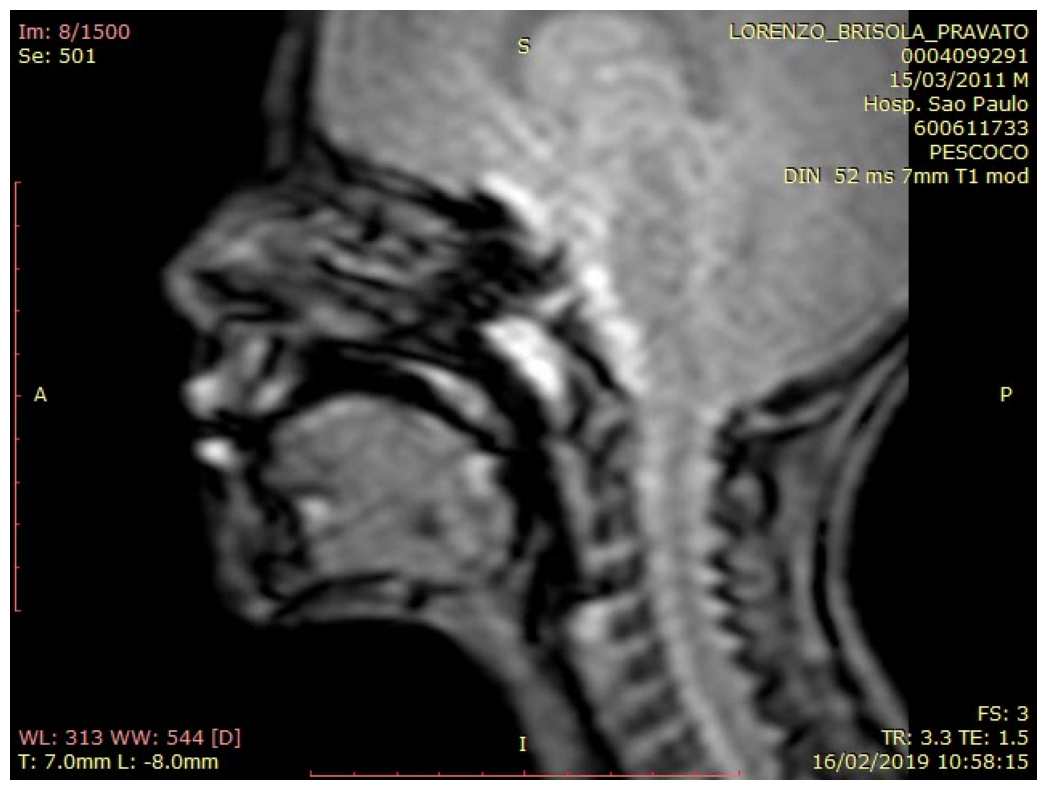

In [15]:
img_id = 7
img = dataset_train.load_image(img_id)
mostrar(img)

In [32]:
mask, class_ids = dataset_test_ruido.load_mask(img_id)

In [33]:
class_ids

array([1, 1])

In [34]:
mask, np.unique(mask, return_counts=True)

(array([[[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        ...,
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [F

In [35]:
dataset_test_ruido

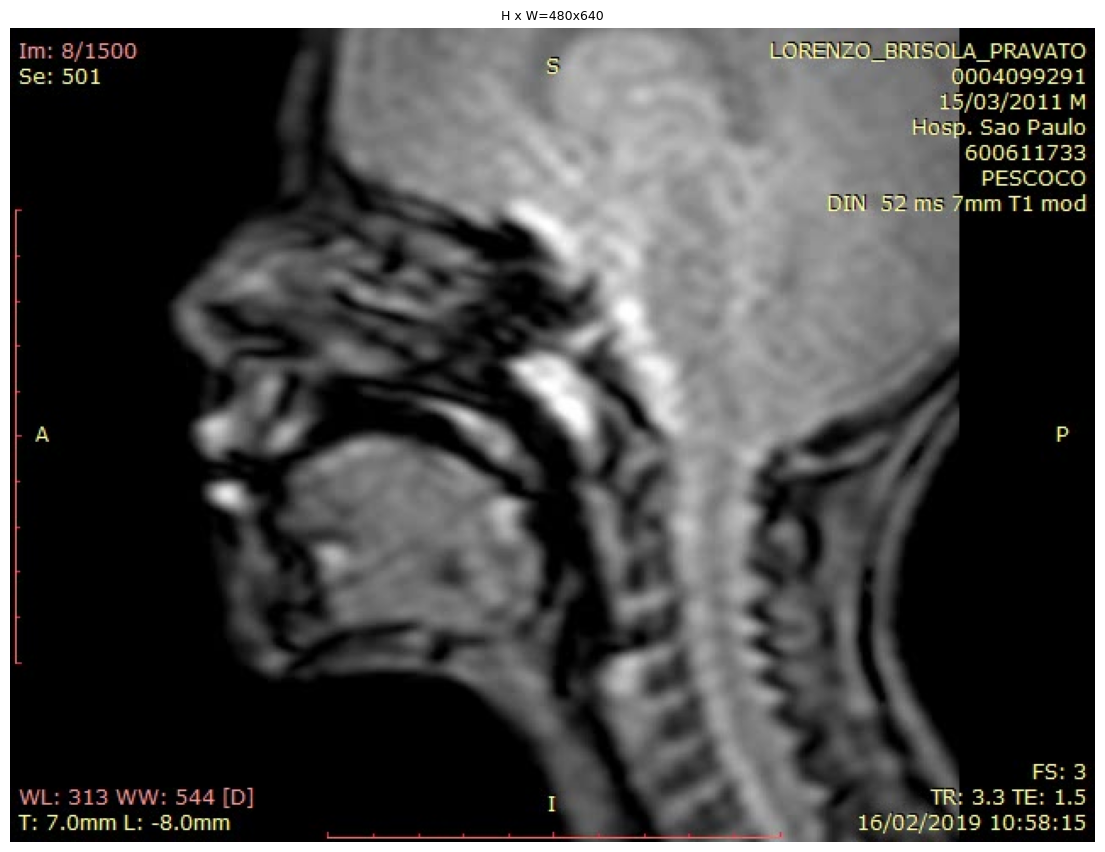

In [38]:
visualize.display_top_masks(img, mask, class_ids, dataset_test_ruido.class_names, 0)

In [37]:
dataset_test_ruido.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

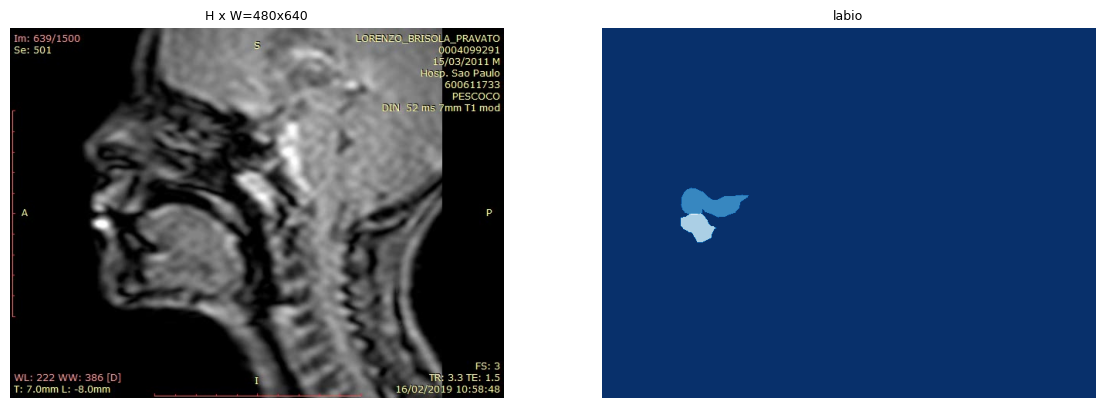

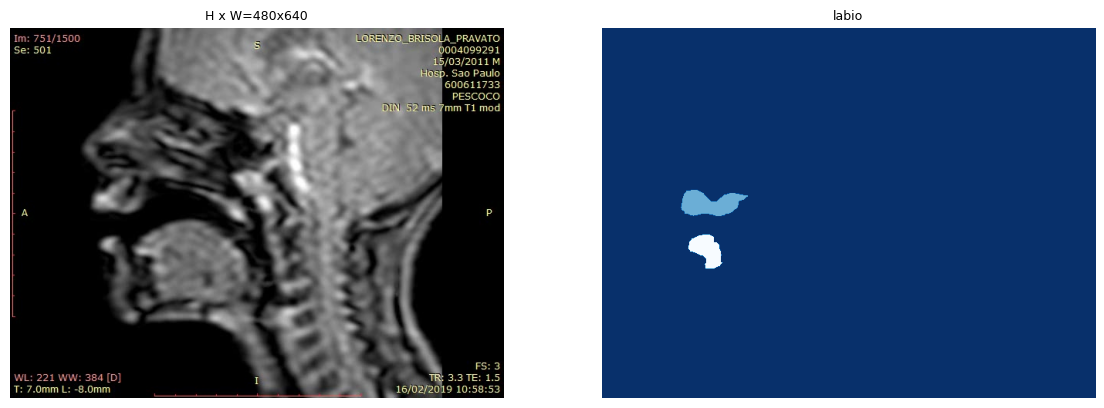

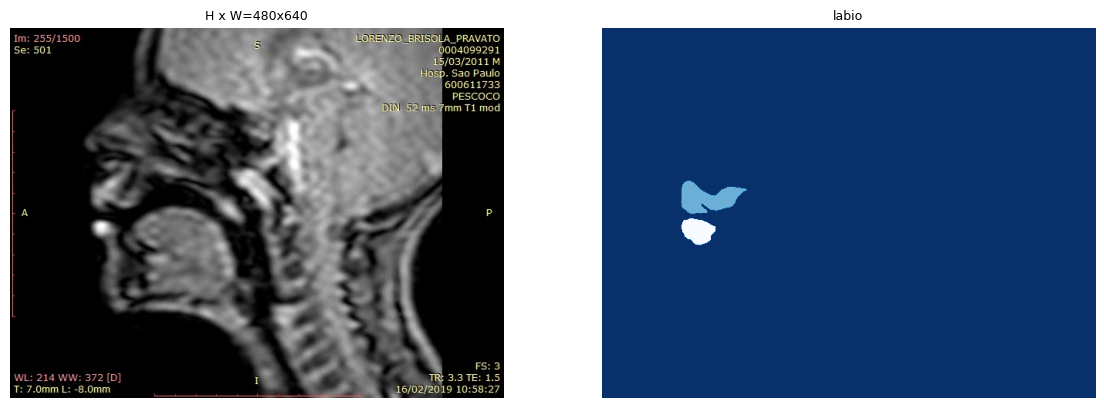

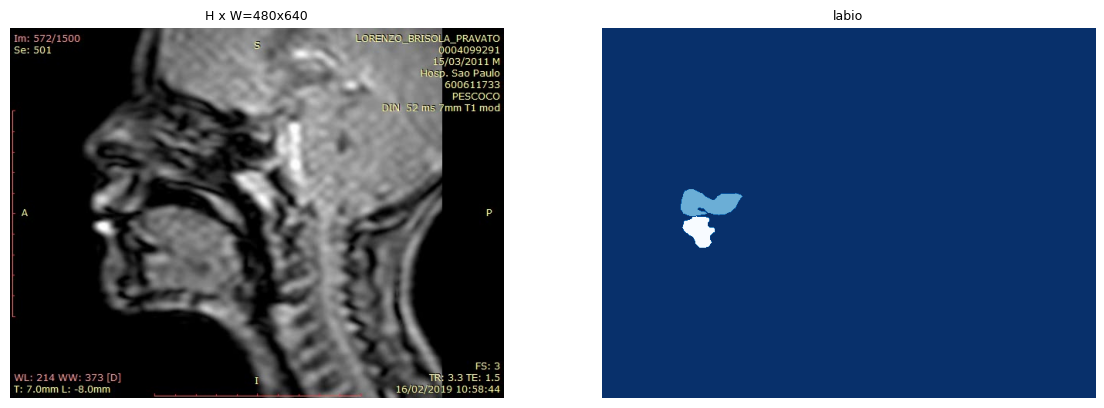

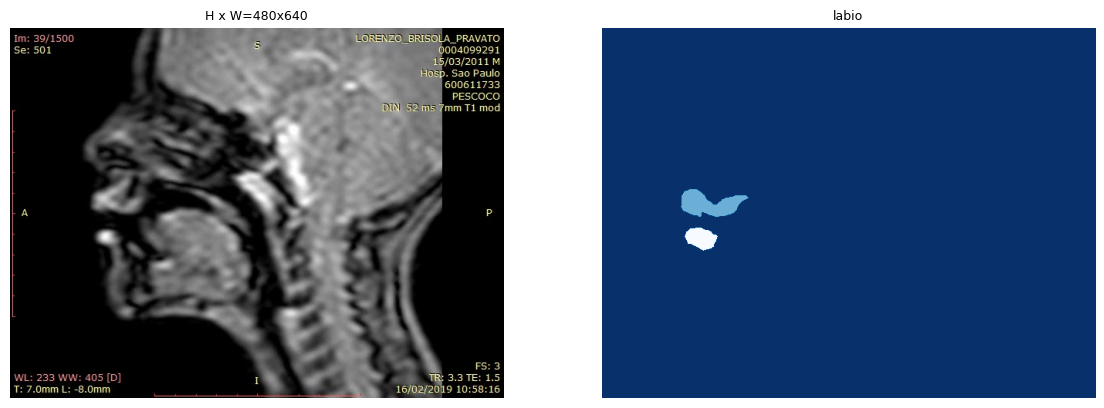

In [18]:
img_ids = np.random.choice(dataset_train.image_ids, 5)
for img_id in img_ids:
  img = dataset_train.load_image(img_id)
  mask, class_ids = dataset_train.load_mask(img_id)
  visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names, 1)

In [39]:
img_id = 7
img = dataset_train.load_image(img_id)
mask, class_ids = dataset_train.load_mask(img_id)
bbox = utils.extract_bboxes(mask)

In [40]:
bbox

array([[225, 105, 258, 184],
       [263, 112, 294, 156]])

In [41]:
print('Imagem', img_id, dataset_train.image_reference(img_id))
log('image', img)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)

Imagem 7 C:/Users/lucas/Documents/Mestrado/epoch\Mask_RCNN-TF2\train\patient_01 0008.jpg
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (480, 640, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:  105.00000  max:  294.00000  int32


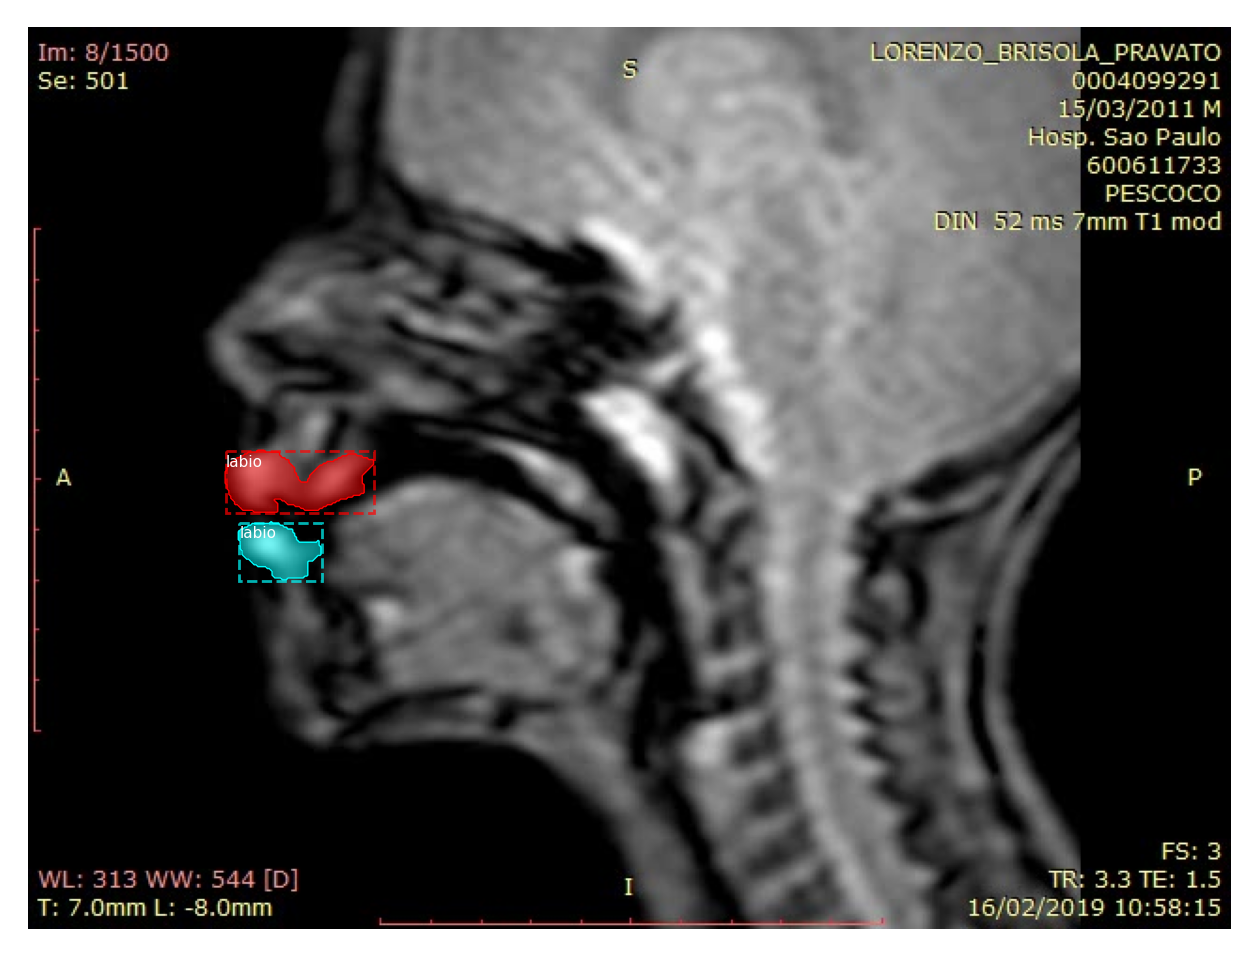

In [22]:
visualize.display_instances(img, bbox, mask, class_ids, dataset_train.class_names, show_bbox=True)

#Atualização de Compatibilidade

In [42]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#Configuração de Rede Neural

In [43]:
class ConfigRede(Config):
  NAME = 'labio'
  IMAGES_PER_GPU = 1
  NUM_CLASSES = 1 + 1
  STEPS_PER_EPOCH = 100
  DETECTION_MIN_CONFIDENCE = 0.9
  USE_MINI_MASK=False
config = ConfigRede()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [44]:
path_modelos = os.path.join(path_raiz, 'logs')
path_modelos

'C:\\Users\\lucas\\Documents\\Mestrado\\epoch\\Mask_RCNN-TF2\\logs'

Carregamento dos pesos

In [45]:
# Transferência de aprendizagem
path_modelo_COCO = os.path.join(path_raiz, 'mask_rcnn_coco.h5')
path_modelo_COCO

'C:\\Users\\lucas\\Documents\\Mestrado\\epoch\\Mask_RCNN-TF2\\mask_rcnn_coco.h5'

In [46]:
if not os.path.exists(path_modelo_COCO):
  utils.download_trained_weights(path_modelo_COCO)

In [47]:
def carrega_modelo_treinamento(config, inicia_com = 'coco', model_path=''):
  model = modellib.MaskRCNN(mode = 'training', config = config, model_dir=model_path)
  if inicia_com == 'coco':
    model.load_weights(path_modelo_COCO, by_name = True, exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
  elif inicia_com == 'imagenet':
    model.load_weights(model.get_imagenet_weights(), by_name=True)
  elif inicia_com == 'last':
    if model_path == "":
      model_path = model.find_last()
    model.load_weights(model_path, by_name=True)

  return model

In [48]:
model = carrega_modelo_treinamento(config, 'coco')

#Treinamento

In [75]:
inicio = time.time()
model.train(dataset_train, dataset_val, learning_rate = config.LEARNING_RATE, epochs = 25, layers='heads') # all
fim_treino = time.time()
minutos = round((fim_treino - inicio) / 60, 2)
print('Tempo de treinamento: ', minutos)


Starting at epoch 0. LR=0.001

Checkpoint Path: labio20230409T1657\mask_rcnn_labio_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_cla

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/25


c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_5/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier_5/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier_5/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier_5/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gr

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 1.1782 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3356 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.2820 

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 4189s 42s/step - batch: 49.5000 - size: 1.0000 - loss: 1.1782 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3356 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.2820 - val_loss: 0.7349 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.1987 - val_mrcnn_class_loss: 0.0414 - val_mrcnn_bbox_loss: 0.2636 - val_mrcnn_mask_loss: 0.2236
Epoch 2/25
100/100 [==============================] - 3983s 40s/step - batch: 49.5000 - size: 1.0000 - loss: 0.6062 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.1904 - val_loss: 0.5658 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.1246 - val_mrcnn_class_loss: 0.0363 - val_mrcnn_bbox_loss: 0.1885 - val_mrcnn_mask_loss: 0.2119
Epoch 3/25
100/100 [==============================] - 3937s 39s/step - batch: 49.5000 - size: 1.0000 - loss: 0.5070 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.03

Teste

In [49]:
class InferenceConfig(ConfigRede):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

In [50]:
def carrega_modelo_teste(model_path='ultimo'):
  inference_config = InferenceConfig()
  model = modellib.MaskRCNN(mode = 'inference', config=inference_config, model_dir=model_path)
  if model_path == 'ultimo':
    model_path = model.find_last()
  print('Carregando os pesos de', model_path)
  model.load_weights(model_path, by_name=True)
  return model, inference_config

In [51]:
model_teste, inference_config = carrega_modelo_teste('C:/Users/lucas/Documents/Mestrado/epoch/Mask_RCNN-TF2/labio20230409T1657/mask_rcnn_labio_0001.h5')

Instructions for updating:
Use fn_output_signature instead
Carregando os pesos de C:/Users/lucas/Documents/Mestrado/epoch/Mask_RCNN-TF2/labio20230409T1657/mask_rcnn_labio_0001.h5
Re-starting from epoch 1


In [53]:
from skimage.io import imread
def segmentar_imagem(model_teste, img):
  resultados = model_teste.detect([img], verbose=0)
  r = resultados[0]
  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(12,10))
  return r